In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pprint
import math

pd.reset_option('all')

# Utility Functions #
def place_to_column(place, colType='Player'):
    if place == 'Draw':
        return
    return f'{colType} {place}'

def data_columns(colType='Player'):
    return [f'{colType} 1', f'{colType} 2', f'{colType} 3', f'{colType} 4']

def filter_games_by_value(value, args=None, df=None, cols: list = None):
    if args:
        df, cols = args
    return df.loc[(df[cols[0]] == value) | (df[cols[1]] == value) | (df[cols[2]] == value) | (df[cols[3]] == value)]

def filter_out_value(value, args=None, df=None, cols: list = None):
    if args:
        df, cols = args
    return df.loc[(value not in df[cols[0]]) | (value not in df[cols[1]]) | (value not in df[cols[2]]) | (value not in df[cols[3]])]
                                                                                                          

In [2]:
cedh = pd.read_csv('cedh.csv', parse_dates=['Date'])

# The "Winning Place" column is normally just a number from 1-4.
# This turns it into a string with value "Deck/Player/Mulligans 1/2/3/4"
# This string is then used as a column name in a loc, which is a bit grimy but not too bad

winningDeck = cedh['Winning Place'].apply(lambda x: f'Deck {x}')
winningPlayer= cedh['Winning Place'].apply(lambda x: f'Player {x}')
winningKeep = cedh['Winning Place'].apply(lambda x: f'Mulligans {x}')
winnerD, winnerP, winnerM = [], [], []

for i, row in cedh.iterrows():
    if winningDeck[i] == 'Deck 0': # Only need to check this one because if one frame is a draw they'll all be a draw
        winnerD.append("Draw")
        winnerP.append("Draw")
        winnerM.append("Draw")
    else:
        winnerD.append(cedh.iloc[i].loc[winningDeck[i]])
        winnerP.append(cedh.iloc[i].loc[winningPlayer[i]])
        winnerM.append(cedh.iloc[i].loc[winningKeep[i]])
    
decks = cedh[data_columns(colType='Deck') + ['Victory Turn', 'Date']]
players = cedh[data_columns(colType='Player') + ['Victory Turn', 'Winning Place', 'Date']]
kept = cedh[data_columns(colType='Mulligans') + ['Victory Turn', 'Winning Place', 'Date']]
decks = decks.assign(Winner=winnerD)
players = players.assign(Winner=winnerP)
mulligans = players.assign(Winner=winnerM)

In [3]:
filtered_players = players[players['Date'] >= '2024-09-23']
old_players = players[players['Date'] <= '2024-09-23']

filtered_decks = decks[decks['Date'] >= '2024-09-23']
old_decks = decks[decks['Date'] <= '2024-09-23']

target_decks = filtered_decks # set it to use the filtered values or not
target_players = filtered_players

print(target_decks[['Deck 1', 'Victory Turn']])

                        Deck 1  Victory Turn
59                      Kinnan           3.0
60                      Yuriko           3.0
61                       Flubs           4.0
62                      Kinnan           3.0
63                      K’rrik           4.0
..                         ...           ...
351                      Esika           7.0
352  Narset, Enlightened Exile           4.0
353   The Master, Transcendent           7.0
354                      Sisay           6.0
355                      Rocco           6.0

[297 rows x 2 columns]


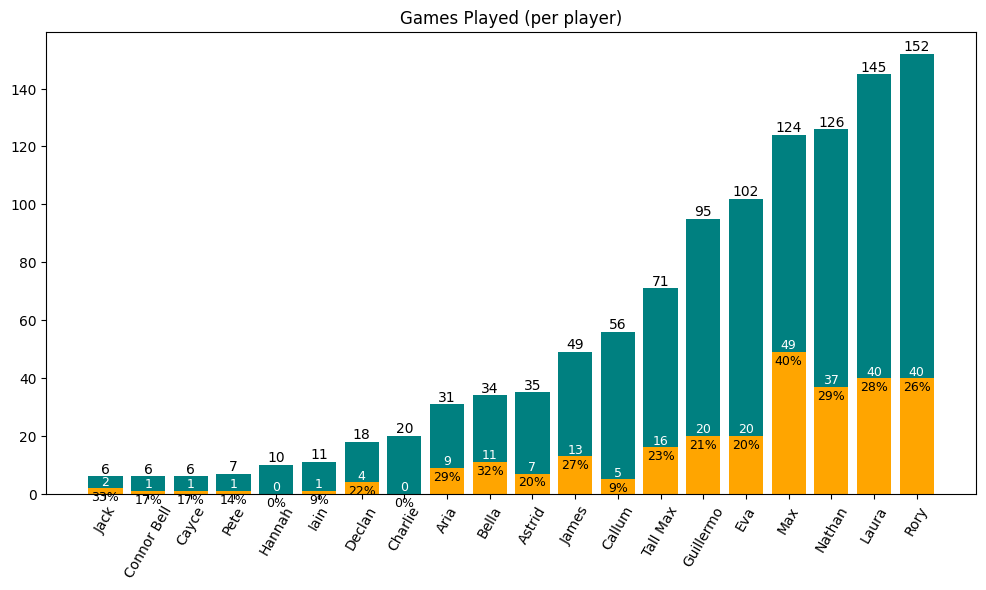

In [4]:
player_freq = target_players[data_columns()].apply(pd.value_counts, axis=1).sum().drop(['Tournament 1', 'Tournament 2', 'Tournament 3', 'Tournament 4']).sort_values().astype(int)
player_freq_pruned = player_freq[player_freq > 5]
player_win_freq = target_players[['Winner']].value_counts().reset_index(level=[0]).set_index('Winner')

player_win_data = pd.DataFrame(index=player_freq_pruned.index, data=player_freq_pruned, columns=['Games'])
player_win_data['Wins'] = player_win_freq['count'].astype(int)
player_win_data.fillna(0, inplace=True)
player_win_data['Winrate'] = (player_win_data['Wins'] / player_win_data['Games']) * 100

fig, ax = plt.subplots()
fig.set_size_inches(12,6)
win_percent = player_win_data['Winrate'].apply('{:,.0f}%'.format)

total = ax.bar(player_win_data.index, player_win_data['Games'], color='teal')
wins = ax.bar(player_win_data.index, player_win_data['Wins'], color='orange')

ax.bar_label(wins, player_win_data['Wins'].astype(int), fontsize=9, color='white')
ax.bar_label(wins, win_percent, padding=-11, fontsize=9)
ax.bar_label(total, player_win_data['Games'])

plt.xticks(rotation=60)
plt.title('Games Played (per player)')
plt.show()
#print(player_freq)

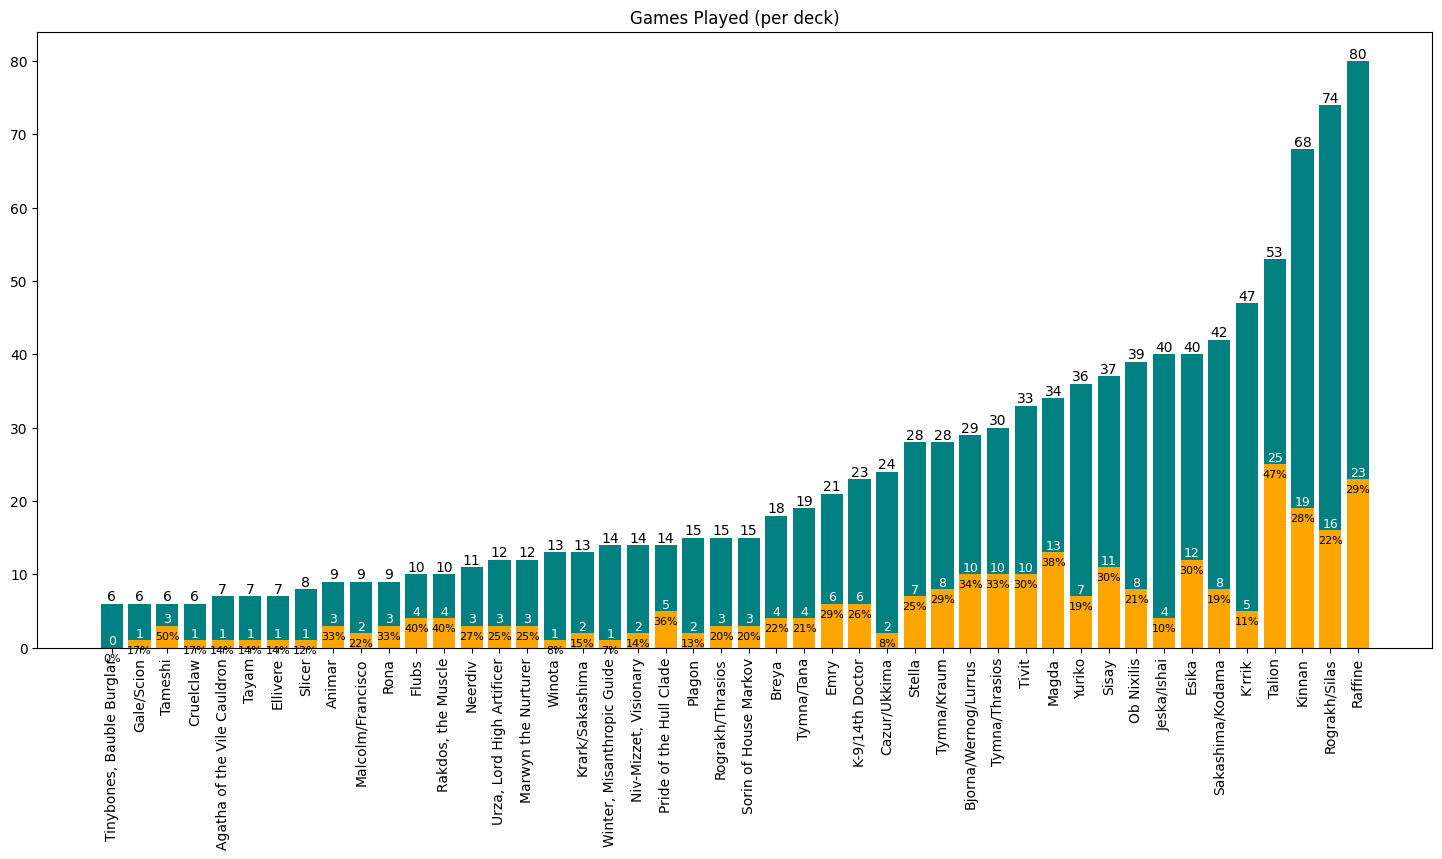

In [85]:
deck_freq = target_decks[data_columns(colType='Deck')].apply(pd.value_counts, axis=1).sum().sort_values().astype(int)
deck_freq_pruned = deck_freq[deck_freq > 5]
deck_win_freq = target_decks[['Winner']].value_counts().reset_index(level=[0]).set_index('Winner')

deck_win_data = pd.DataFrame(index=deck_freq_pruned.index, data=deck_freq_pruned, columns=['Games'])
deck_win_data['Wins'] = deck_win_freq['count'].astype(int)
deck_win_data.fillna(0, inplace=True)
deck_win_data['Winpct'] = (deck_win_data['Wins'] / deck_win_data['Games']) * 100
deck_win_data['Deviation'] = decks[['Winner', 'Victory Turn']].dropna(subset=['Victory Turn']).groupby('Winner').std()

fig, ax = plt.subplots()
fig.set_size_inches(18,8)
win_percent = deck_win_data['Winpct'].apply('{:,.0f}%'.format)

total = ax.bar(deck_win_data.index, deck_win_data['Games'].astype(int), color='teal')
#errors = ax.bar(deck_win_data.index, deck_win_data['Winrate'], color='orange', yerr=deck_win_data['Deviation'], error_kw={'capsize':8.0, 'elinewidth': 0, 'ecolor':'w'})
wins = ax.bar(deck_win_data.index, deck_win_data['Wins'], color='orange')

ax.bar_label(wins, deck_win_data['Wins'].astype(int), fontsize=9, color='white')
ax.bar_label(wins, win_percent, padding=-11, fontsize=8)
ax.bar_label(total, deck_win_data['Games'])

plt.xticks(rotation=90)
plt.title('Games Played (per deck)')
plt.show()

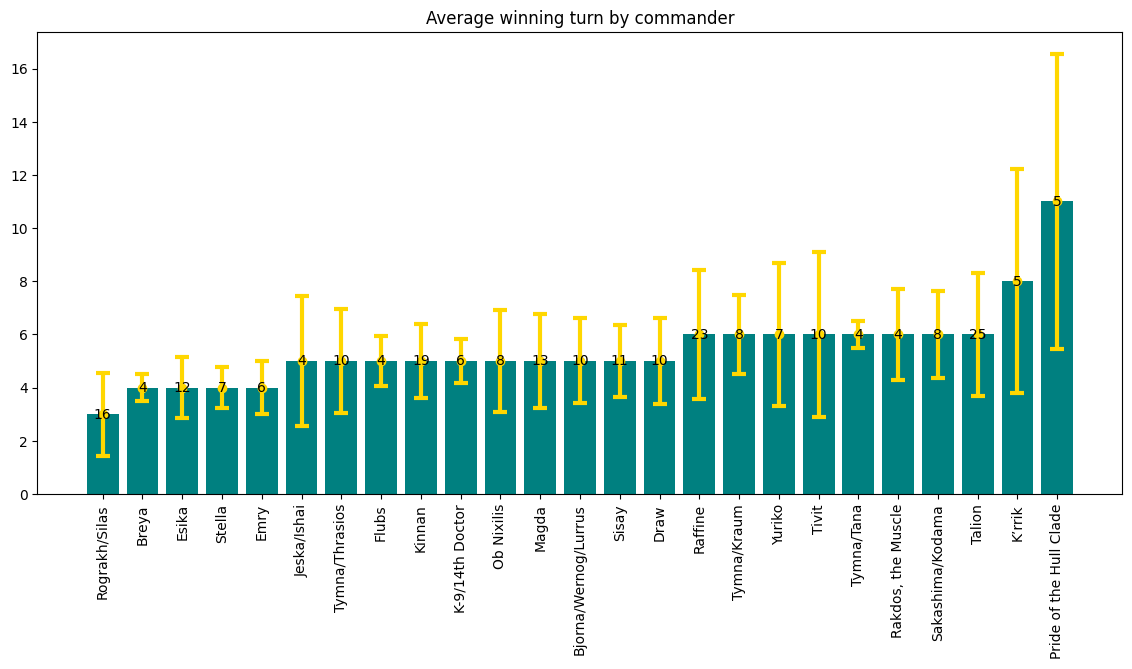

In [6]:
deckWins = target_decks[['Winner', 'Victory Turn']].groupby('Winner').mean().sort_values(by='Victory Turn')
deckWins['Deviation'] = target_decks[['Winner', 'Victory Turn']].dropna(subset=['Victory Turn']).groupby('Winner').std()

deckWins['Count'] = target_decks['Winner'].value_counts()
deckWins.rename(columns={'Victory Turn': 'Avg Turn'}, inplace=True)

target_wins = deckWins[deckWins['Count'] > 3]

fig, ax = plt.subplots()
fig.set_size_inches(14,6)

wins = ax.bar(target_wins.index, target_wins['Avg Turn'].astype(int), color='teal')
error = ax.errorbar(target_wins.index, target_wins['Avg Turn'].astype(int), color='gold', yerr=target_wins['Deviation'], fmt='o', elinewidth=3, capsize=5, capthick=3)

ax.bar_label(wins, target_wins['Count'], fontsize=10, color='black', padding=-5)

plt.xticks(rotation=90)
plt.title('Average winning turn by commander')
plt.show()

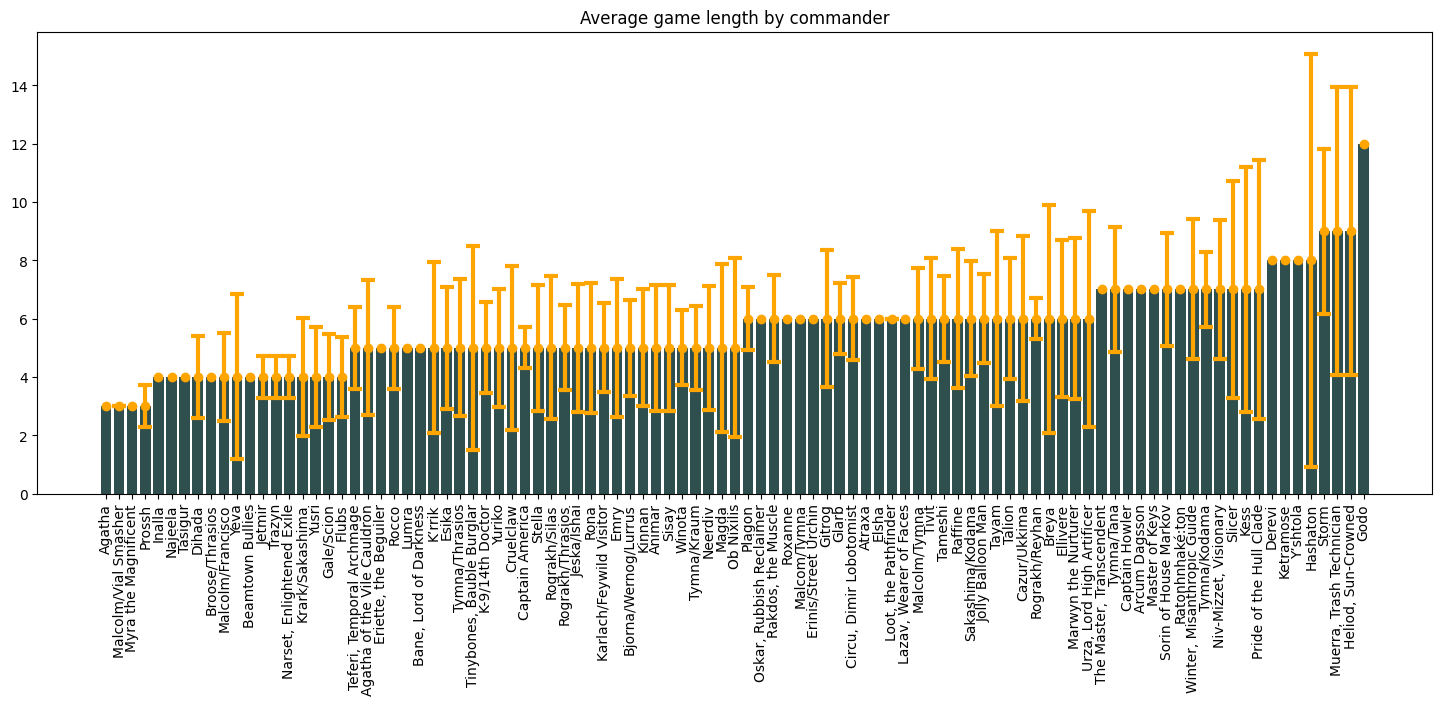

In [7]:
deck_1 = target_decks[['Deck 1', 'Victory Turn']].rename(columns={'Deck 1': 'Deck'})
deck_2 = target_decks[['Deck 2', 'Victory Turn']].rename(columns={'Deck 2': 'Deck'})
deck_3 = target_decks[['Deck 3', 'Victory Turn']].rename(columns={'Deck 3': 'Deck'})
deck_4 = target_decks[['Deck 4', 'Victory Turn']].rename(columns={'Deck 4': 'Deck'})

all_decks_raw = pd.concat([deck_1, deck_2, deck_3, deck_4])

all_decks = all_decks_raw.groupby('Deck').mean().sort_values(by='Victory Turn')
all_decks['Deviation'] = all_decks_raw.groupby('Deck').std()
#print(all_decks)

fig, ax = plt.subplots()
fig.set_size_inches(18,6)

wins = ax.bar(all_decks.index, all_decks['Victory Turn'].astype(int), color='darkslategrey')
error = ax.errorbar(all_decks.index, all_decks['Victory Turn'].astype(int), color='orange', yerr=all_decks['Deviation'], fmt='o', elinewidth=3, capsize=5, capthick=3)

plt.xticks(rotation=90)
plt.title('Average game length by commander')
plt.show()

Power_divergenceResult(statistic=62.57912457912458, pvalue=8.321045836494501e-13)

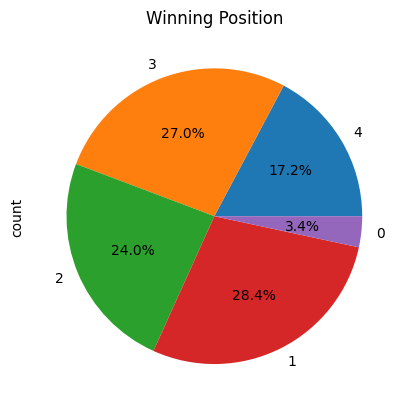

In [8]:
(target_players[~target_players['Player 4'].isna()]["Winning Place"]
 .value_counts()
 .sort_index(ascending=False)
 .plot.pie(title='Winning Position', autopct=lambda x:'{:.1f}%'.format(x)))

sp.stats.chisquare(target_players['Winning Place'].value_counts())

<Axes: ylabel='Frequency'>

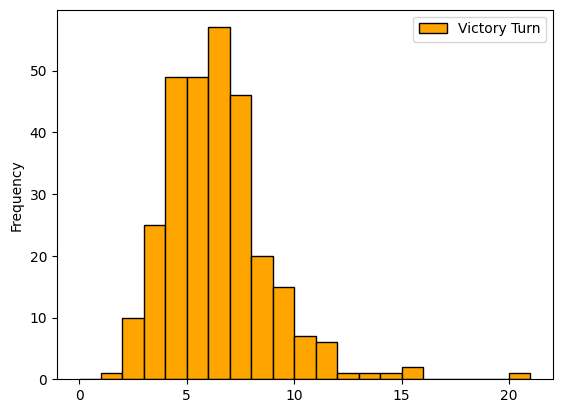

In [9]:
longest = max(target_players['Victory Turn'])
target_players.plot.hist(column=['Victory Turn'], bins=int(longest), histtype='bar', ec='black', color='orange')

Power_divergenceResult(statistic=266.0179104477612, pvalue=1.542433795210163e-54)

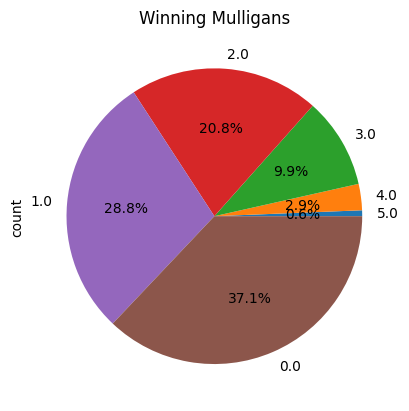

In [29]:
mulligans[mulligans['Winner'] != 'Draw'].dropna()['Winner'].value_counts().sort_values().plot.pie(title='Winning Mulligans', autopct=lambda x:'{:.1f}%'.format(x))
sp.stats.chisquare(mulligans['Winner'].value_counts())

In [28]:
straights = ['Guillermo', 'Nathan', 'Callum', 'James', 'Ted', 'Jack']
gaywin = target_players[~target_players['Winner'].isin(straights)].shape[0]
print(f'{gaywin} / {target_players.shape[0]} - {gaywin/target_players.shape[0] * 100:,.0f}%')

219 / 297 - 74%


In [25]:
cisses = ['Connor Bell', 'Declan', 'Guillermo', 'Iain', 'James', 'Pete', 'Callum', 'Hannah', 'Nathan', 'Ted', 'Rian', 'Jack']
transwin = target_players[~target_players['Winner'].isin(cisses)].shape[0]
print(f'{transwin} / {target_players.shape[0]} - {transwin/target_players.shape[0] * 100:,.0f}%')

210 / 297 - 71%


In [84]:
filter_games_by_value('Raffine', cols=data_columns(colType='Deck'), df=filter_games_by_value('Esika', cols=data_columns(colType='Deck'), df=target_decks))


,Deck 1,Deck 2,Deck 3,Deck 4,Victory Turn,Date,Winner
255,Esika,Rograkh/Silas,Raffine,"Tinybones, Bauble Burglar",5.0,2024-12-30,Esika
274,Esika,Tivit,Raffine,K-9/14th Doctor,7.0,2025-01-13,Esika
281,Sisay,Malcolm/Francisco,Esika,Raffine,4.0,2025-01-21,Esika
340,Myra the Magnificent,Esika,K’rrik,Raffine,3.0,2025-02-22,Esika


In [14]:
target_decks[target_decks["Winner"] == 'Draw']

,Deck 1,Deck 2,Deck 3,Deck 4,Victory Turn,Date,Winner
320,Animar,Sisay,Kinnan,Kinnan,7.0,2025-02-17,Draw
321,Sisay,Talion,Kinnan,Esika,NaN,2025-02-03,Draw
322,Esika,Agatha,Tymna/Thrasios,Malcolm/Francisco,3.0,2025-01-25,Draw
323,Magda,Sisay,Raffine,Sorin of House Markov,8.0,2024-12-14,Draw
324,Slicer,Jeska/Ishai,Esika,Talion,5.0,2024-12-11,Draw
325,Raffine,Tymna/Kraum,Sorin of House Markov,Flubs,6.0,2024-12-08,Draw
332,Plagon,Talion,Tivit,Tymna/Kraum,7.0,2025-02-22,Draw
335,Tameshi,"Rakdos, the Muscle",Tymna/Thrasios,Malcolm/Tymna,4.0,2025-02-24,Draw
351,Esika,Plagon,Talion,Sisay,7.0,2025-02-21,Draw
354,Sisay,Tivit,Erinis/Street Urchin,Glarb,6.0,2025-02-22,Draw


<Axes: title={'center': 'Matchups (bottom is winner)'}>

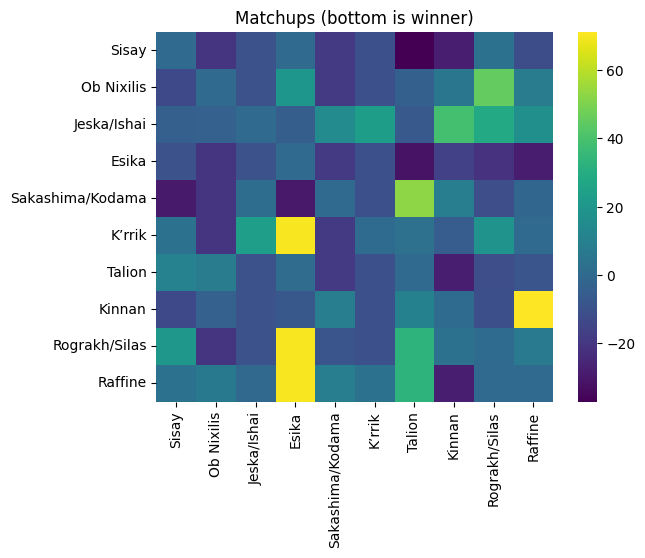

In [83]:
deck_freq = target_decks[data_columns(colType='Deck')].apply(pd.value_counts, axis=1).sum().sort_values().astype(int)
deck_freq_pruned = deck_freq.tail(10)
non_null_games_with_decks = deck_freq_pruned.dropna()
all_decks = non_null_games_with_decks.index

matchups_by_deck = {}
for d1 in all_decks:
    games_with_d1 = filter_games_by_value(d1, cols=data_columns(colType='Deck'), df=target_decks)
    matchups = []
    for d2 in all_decks:
        games_with_d1_d2 = filter_games_by_value(d2, cols=data_columns(colType='Deck'), df=games_with_d1)
        count_games = games_with_d1_d2.shape[0]
        if count_games == 0:
            matchups.append(None)
            continue
        games_won_by_d1 = games_with_d1_d2[games_with_d1_d2['Winner'] == d1].shape[0]
        winrate = (games_won_by_d1 / count_games) * 100 
        relative_winrate = winrate - deck_win_data.loc[d1].Winpct
        #print(f'{d1} / {d2}: {relative_winrate}')
        matchups.append(relative_winrate)
    matchups_by_deck[d1] = matchups
    
all_matchups = pd.DataFrame(matchups_by_deck, index=list(all_decks), columns=list(all_decks))
#print(all_matchups)
ax = plt.axes()
ax.set_title('Matchups (bottom is winner)')
sns.heatmap(all_matchups, cmap='viridis', ax=ax)